# RBE Part 1: Uncertainty Fundamentals

> Understanding uncertainty in cybersecurity: types, mathematics, and practical applications

In [ ]:
#| default_exp rbe.uncertainty

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.test import test_eq, test_close
from fastcore.all import *
# Import specific functions we need
from technical_blog.rbe.probability import normalize as prob_normalize, entropy as prob_entropy
from technical_blog.rbe.bayes_core import update as bayes_update, sequential as bayes_sequential
from technical_blog.rbe.viz import beliefs as viz_beliefs
from fasthtml.common import *
from typing import List, Dict, Tuple

## Introduction: Why Uncertainty Matters in Cybersecurity

In cybersecurity, we constantly make decisions under uncertainty. Consider these scenarios:

1. **Network Anomaly Detection**: Is this unusual traffic pattern a cyberattack or normal variation?
2. **Threat Intelligence**: How confident are we that this IP address is malicious?
3. **Incident Response**: What's the probability this breach came from an insider threat?

Traditional approaches often ignore uncertainty, leading to brittle systems that fail when conditions change. Recursive Bayesian Estimation (RBE) provides a principled framework for handling uncertainty that evolves over time.

Let's start with a concrete example:

In [ ]:
# Example: Network intrusion detection uncertainty
# We observe suspicious activity but aren't sure if it's an attack

# Prior belief: 5% of network events are attacks
prior_attack = 0.05
prior_normal = 0.95
prior = np.array([prior_attack, prior_normal])

print(f"Prior belief: {prior_attack*100:.1f}% chance of attack")
print(f"Uncertainty (entropy): {prob_entropy(prior):.3f} bits")

This entropy measure tells us how uncertain we are. Higher entropy = more uncertainty. Now let's see how new evidence changes our beliefs:

In [ ]:
# New evidence: unusual port scanning detected
# Likelihood: attacks cause port scanning 90% of the time
#            normal traffic causes it 10% of the time
likelihood = np.array([0.9, 0.1])  # [P(evidence|attack), P(evidence|normal)]

# Update beliefs using Bayes' theorem
posterior = bayes_update(prior, likelihood)

print(f"After observing port scanning:")
print(f"Updated belief: {posterior[0]*100:.1f}% chance of attack")
print(f"New uncertainty: {prob_entropy(posterior):.3f} bits")
print(f"Uncertainty reduction: {prob_entropy(prior) - prob_entropy(posterior):.3f} bits")

Notice how the evidence both **increased our confidence** in an attack and **reduced our uncertainty**. This is the essence of Bayesian reasoning - we start with prior beliefs and update them as we gather evidence.

## Types of Uncertainty

Understanding uncertainty requires distinguishing between two fundamental types:

### Aleatory Uncertainty (Irreducible)
**Inherent randomness** in the system that cannot be reduced by gathering more data.

**Cybersecurity Examples:**
- Random timing of legitimate user logins
- Network packet loss due to congestion
- Attacker's choice of target systems

### Epistemic Uncertainty (Reducible)
**Lack of knowledge** that can be reduced by collecting more information.

**Cybersecurity Examples:**
- Unknown attack signatures
- Incomplete threat intelligence
- Uncertain system configurations

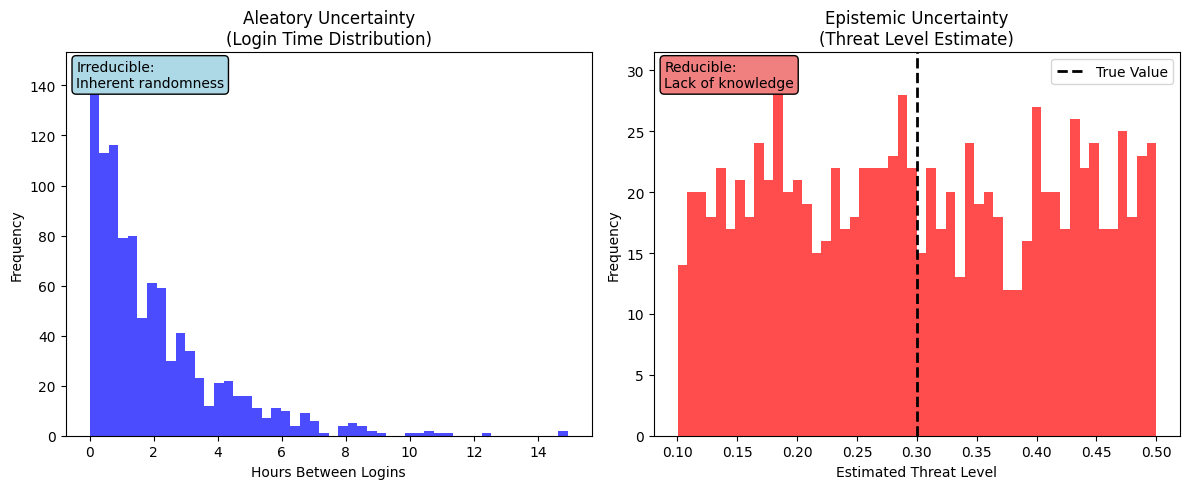

Aleatory uncertainty (login times): mean=2.03 hours
Epistemic uncertainty range: 0.10 to 0.50
True threat level: 0.3 (unknown to us initially)


In [ ]:
#| export
def demo_uncertainty_types(n_samples=1000, rng=None):
    """Demonstrate aleatory vs epistemic uncertainty with cybersecurity examples"""
    if rng is None: rng = np.random.default_rng(42)
    
    # Aleatory: Login times follow a random distribution (irreducible)
    # Even if we know the distribution perfectly, individual login times are unpredictable
    login_times = rng.exponential(scale=2.0, size=n_samples)  # Hours between logins
    
    # Epistemic: Attack probability depends on unknown threat level (reducible)
    # As we gather more intelligence, we can better estimate the true threat level
    true_threat_level = 0.3  # Unknown to us initially
    
    # Our epistemic uncertainty: we think threat level is between 0.1 and 0.5
    epistemic_samples = rng.uniform(0.1, 0.5, size=n_samples)
    
    return {
        'aleatory': login_times,
        'epistemic': epistemic_samples,
        'true_threat': true_threat_level
    }

# Demonstrate the difference
uncertainty_demo = demo_uncertainty_types()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Aleatory uncertainty: login time distribution
ax1.hist(uncertainty_demo['aleatory'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Aleatory Uncertainty\n(Login Time Distribution)')
ax1.set_xlabel('Hours Between Logins')
ax1.set_ylabel('Frequency')
ax1.text(0.02, 0.98, 'Irreducible:\nInherent randomness', 
         transform=ax1.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='lightblue'))

# Epistemic uncertainty: our belief about threat level
ax2.hist(uncertainty_demo['epistemic'], bins=50, alpha=0.7, color='red')
ax2.axvline(uncertainty_demo['true_threat'], color='black', linestyle='--', linewidth=2, label='True Value')
ax2.set_title('Epistemic Uncertainty\n(Threat Level Estimate)')
ax2.set_xlabel('Estimated Threat Level')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.text(0.02, 0.98, 'Reducible:\nLack of knowledge', 
         transform=ax2.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='lightcoral'))

plt.tight_layout()
plt.show()

print(f"Aleatory uncertainty (login times): mean={np.mean(uncertainty_demo['aleatory']):.2f} hours")
print(f"Epistemic uncertainty range: {np.min(uncertainty_demo['epistemic']):.2f} to {np.max(uncertainty_demo['epistemic']):.2f}")
print(f"True threat level: {uncertainty_demo['true_threat']} (unknown to us initially)")

**Key Insight**: RBE excels at handling epistemic uncertainty. As we collect more evidence, our beliefs converge toward the truth. Aleatory uncertainty remains, but we can quantify and account for it.

## Mathematical Foundations

Let's build our mathematical toolkit using the core functions. We'll start with probability distributions and work toward Bayesian inference.

### Probability Distributions and Entropy

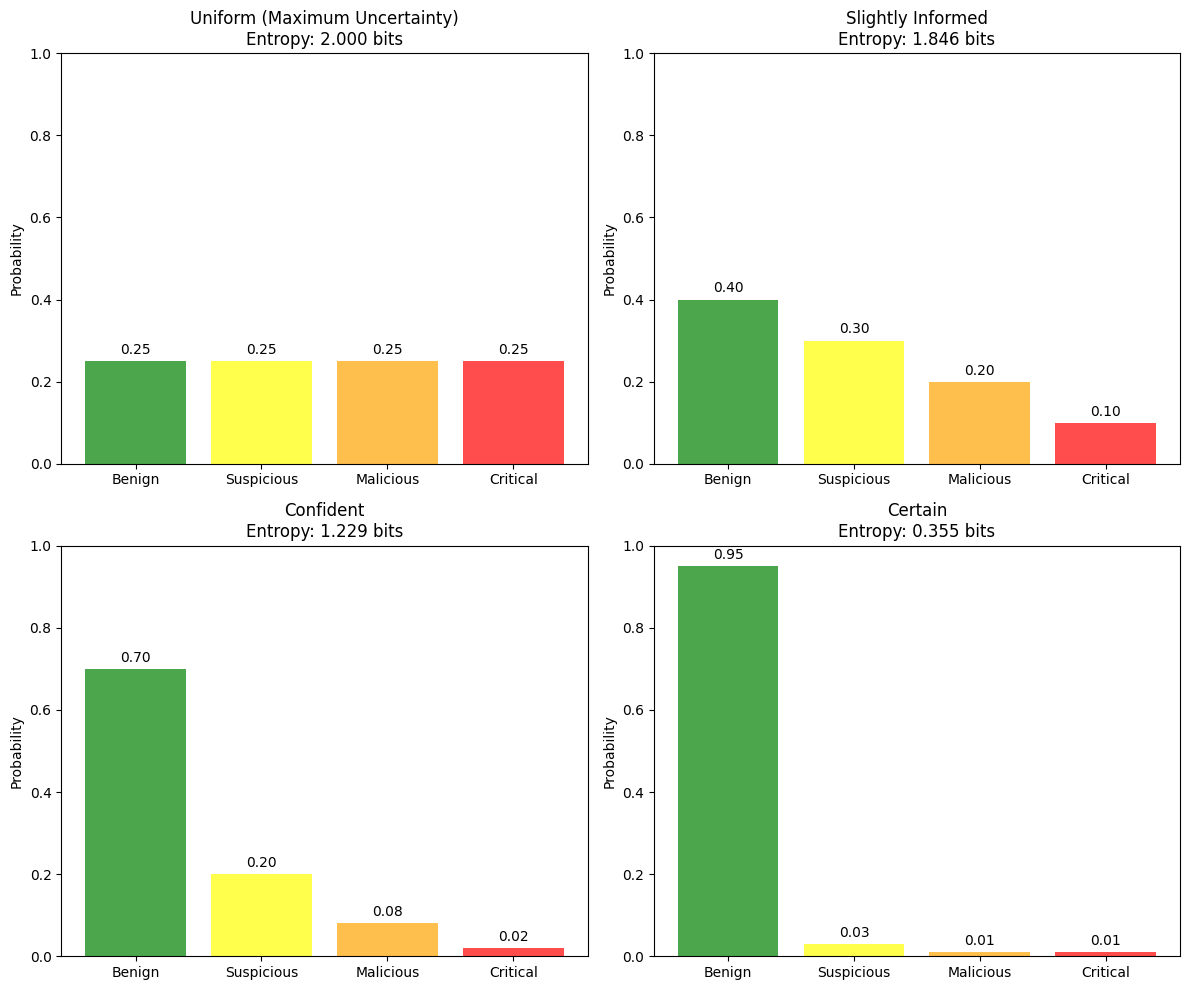


Entropy Analysis:
Uniform (Maximum Uncertainty): 2.000 bits
Slightly Informed: 1.846 bits
Confident: 1.229 bits
Certain: 0.355 bits

Maximum possible entropy (uniform): 2.000 bits
Minimum possible entropy (certain): 0.000 bits


In [ ]:
#| export
def explore_distributions():
    """Interactive exploration of probability distributions and entropy"""
    
    # Different types of distributions with cybersecurity interpretations
    distributions = {
        'Uniform (Maximum Uncertainty)': [0.25, 0.25, 0.25, 0.25],
        'Slightly Informed': [0.4, 0.3, 0.2, 0.1],
        'Confident': [0.7, 0.2, 0.08, 0.02],
        'Certain': [0.95, 0.03, 0.01, 0.01]
    }
    
    labels = ['Benign', 'Suspicious', 'Malicious', 'Critical']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    entropies = []
    
    for i, (name, probs) in enumerate(distributions.items()):
        ax = axes[i]
        
        # Bar chart of probabilities
        bars = ax.bar(labels, probs, alpha=0.7, 
                     color=['green', 'yellow', 'orange', 'red'])
        
        # Calculate entropy
        entropy = prob_entropy(probs)
        entropies.append(entropy)
        
        ax.set_title(f'{name}\nEntropy: {entropy:.3f} bits')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1)
        
        # Add probability values on bars
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{prob:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return distributions, entropies

# Explore different distributions
dists, entropies = explore_distributions()

print("\nEntropy Analysis:")
for (name, _), entropy in zip(dists.items(), entropies):
    print(f"{name}: {entropy:.3f} bits")
    
print(f"\nMaximum possible entropy (uniform): {np.log2(4):.3f} bits")
print(f"Minimum possible entropy (certain): 0.000 bits")

**Entropy Interpretation:**
- **High entropy** (uniform): We're completely uncertain about the threat level
- **Low entropy** (certain): We're confident in our assessment
- **Information gain**: Entropy reduction when we receive evidence

### Bayes' Theorem in Action

Now let's see how Bayes' theorem works in practice for cybersecurity scenarios:

In [ ]:
#| export
def bayesian_intrusion_detection(n_observations=10, rng=None):
    """Demonstrate Bayesian updating for intrusion detection"""
    if rng is None: rng = np.random.default_rng(42)
    
    # Prior: Start with low suspicion
    prior = np.array([0.05, 0.95])  # [attack, normal]
    
    # Define evidence types and their likelihoods
    evidence_types = {
        'port_scan': np.array([0.8, 0.1]),      # Strong indicator of attack
        'failed_login': np.array([0.7, 0.3]),   # Moderate indicator
        'data_transfer': np.array([0.6, 0.4]),  # Weak indicator
        'normal_traffic': np.array([0.1, 0.9])  # Counter-evidence
    }
    
    # Simulate sequence of observations
    observations = rng.choice(list(evidence_types.keys()), size=n_observations, 
                             p=[0.1, 0.2, 0.3, 0.4])  # Mostly normal traffic
    
    # Track evolution of beliefs
    belief_history = [prior.copy()]
    posterior = prior.copy()
    
    print("Bayesian Intrusion Detection Sequence:")
    print(f"Initial belief: {posterior[0]*100:.1f}% attack probability\n")
    
    for i, obs in enumerate(observations):
        likelihood = evidence_types[obs]
        posterior = bayes_update(posterior, likelihood)
        belief_history.append(posterior.copy())
        
        print(f"Step {i+1}: Observed '{obs}'")
        print(f"  Likelihood: [attack={likelihood[0]:.1f}, normal={likelihood[1]:.1f}]")
        print(f"  Updated belief: {posterior[0]*100:.1f}% attack probability")
        print(f"  Uncertainty: {prob_entropy(posterior):.3f} bits\n")
    
    return np.array(belief_history), observations

# Run the demonstration
beliefs, obs_sequence = bayesian_intrusion_detection()

# Visualize the evolution of beliefs
fig, ax = viz_beliefs(beliefs[:, 0], title='Attack Probability Over Time', 
                      figsize=(10, 6))
ax.set_ylabel('Attack Probability')
ax.set_ylim(0, 1)

# Add observation labels
for i, obs in enumerate(obs_sequence):
    ax.annotate(obs, (i+1, beliefs[i+1, 0]), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.7)

plt.show()

**Key Observations:**
1. **Sequential updating**: Each piece of evidence refines our beliefs
2. **Evidence strength matters**: Port scans have bigger impact than normal traffic
3. **Counter-evidence**: Normal traffic observations reduce attack probability
4. **Uncertainty tracking**: We can quantify how confident we are

### Handling Multiple Hypotheses

In real cybersecurity scenarios, we often consider multiple threat types simultaneously:

Multi-Threat Assessment:

Initial Assessment:
  Benign: 85.0%
  Insider: 5.0%
  External: 8.0%
  APT: 2.0%
  Uncertainty: 0.820 bits

After observing: After hours access
  Benign: 55.9%
  Insider: 23.0%
  External: 15.8%
  APT: 5.3%
  Uncertainty: 1.601 bits

After observing: External IP connection
  Benign: 38.2%
  Insider: 7.9%
  External: 43.1%
  APT: 10.8%
  Uncertainty: 1.689 bits

After observing: Privilege escalation
  Benign: 4.1%
  Insider: 10.1%
  External: 64.9%
  APT: 20.9%
  Uncertainty: 1.400 bits


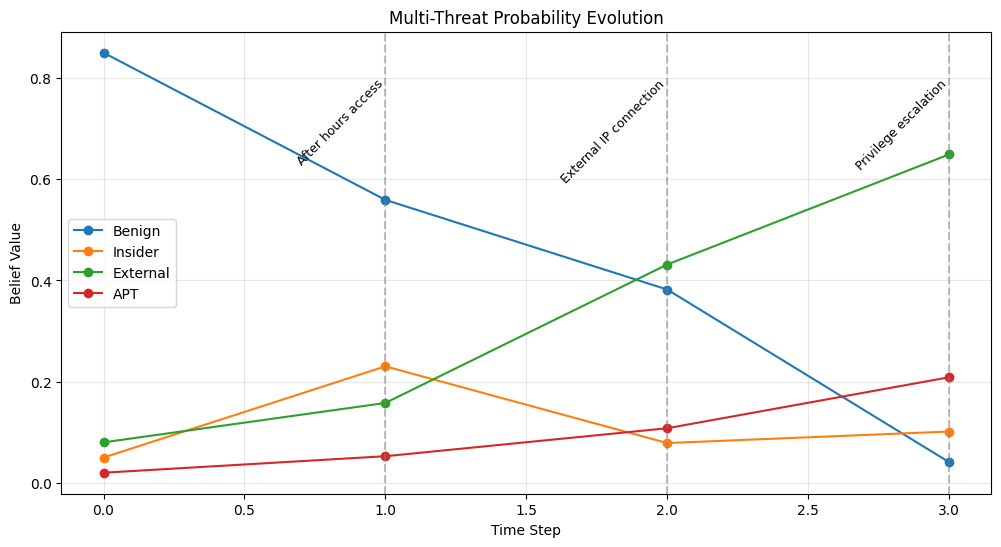

In [ ]:
#| export
def multi_threat_assessment(rng=None):
    """Demonstrate multi-hypothesis threat assessment"""
    if rng is None: rng = np.random.default_rng(42)
    
    # Multiple threat types
    threats = ['Benign', 'Insider', 'External', 'APT']
    
    # Prior beliefs (start with mostly benign assumption)
    prior = np.array([0.85, 0.05, 0.08, 0.02])
    
    # Evidence and likelihood matrices
    evidence_scenarios = {
        'After hours access': np.array([0.1, 0.7, 0.3, 0.4]),
        'External IP connection': np.array([0.2, 0.1, 0.8, 0.6]),
        'Privilege escalation': np.array([0.05, 0.6, 0.7, 0.9]),
        'Data exfiltration': np.array([0.01, 0.4, 0.8, 0.95]),
        'Stealth techniques': np.array([0.02, 0.2, 0.5, 0.9])
    }
    
    # Simulate evidence sequence
    evidence_sequence = ['After hours access', 'External IP connection', 'Privilege escalation']
    
    # Track belief evolution
    beliefs = [prior.copy()]
    current_belief = prior.copy()
    
    print("Multi-Threat Assessment:")
    print("\nInitial Assessment:")
    for i, threat in enumerate(threats):
        print(f"  {threat}: {current_belief[i]*100:.1f}%")
    print(f"  Uncertainty: {prob_entropy(current_belief):.3f} bits")
    
    # Process evidence sequence
    for evidence in evidence_sequence:
        likelihood = evidence_scenarios[evidence]
        current_belief = bayes_update(current_belief, likelihood)
        beliefs.append(current_belief.copy())
        
        print(f"\nAfter observing: {evidence}")
        for i, threat in enumerate(threats):
            print(f"  {threat}: {current_belief[i]*100:.1f}%")
        print(f"  Uncertainty: {prob_entropy(current_belief):.3f} bits")
    
    return np.array(beliefs), threats, evidence_sequence

# Run multi-threat assessment
threat_beliefs, threat_types, evidence_seq = multi_threat_assessment()

# Visualize evolution of all threat probabilities
fig, ax = viz_beliefs(threat_beliefs, labels=threat_types, 
                      title='Multi-Threat Probability Evolution', figsize=(12, 6))

# Add evidence markers
for i, evidence in enumerate(evidence_seq):
    ax.axvline(i+1, color='gray', linestyle='--', alpha=0.5)
    ax.text(i+1, ax.get_ylim()[1]*0.9, evidence, 
            rotation=45, ha='right', va='top', fontsize=9)

plt.show()

## Interactive Uncertainty Explorer

Let's create an interactive component to explore how different evidence affects our beliefs:

In [ ]:
#| export
def create_uncertainty_calculator():
    """Create an interactive uncertainty calculator using FastHTML"""
    
    def uncertainty_form():
        return Form(
            Div(
                H3("Bayesian Uncertainty Calculator"),
                P("Explore how evidence changes beliefs and uncertainty"),
                cls="mb-4"
            ),
            
            # Prior beliefs input
            Div(
                Label("Prior Belief (Attack Probability):"),
                Input(type="range", name="prior", min="0", max="100", value="5", 
                      id="prior-slider", cls="w-full"),
                Span(id="prior-value", cls="text-sm text-gray-600"),
                cls="mb-4"
            ),
            
            # Evidence strength input
            Div(
                Label("Evidence Strength (Likelihood Ratio):"),
                Input(type="range", name="evidence", min="1", max="10", value="5", 
                      id="evidence-slider", cls="w-full"),
                Span(id="evidence-value", cls="text-sm text-gray-600"),
                cls="mb-4"
            ),
            
            # Results display
            Div(
                Div(id="calculation-results", cls="p-4 bg-gray-100 rounded"),
                cls="mb-4"
            ),
            
            # JavaScript for interactivity
            Script("""
            function updateCalculation() {
                const prior = document.getElementById('prior-slider').value / 100;
                const evidence = document.getElementById('evidence-slider').value;
                
                document.getElementById('prior-value').textContent = (prior * 100).toFixed(1) + '%';
                document.getElementById('evidence-value').textContent = evidence + 'x';
                
                // Calculate posterior using Bayes' theorem
                const likelihood = evidence;
                const posterior = (prior * likelihood) / (prior * likelihood + (1 - prior));
                
                // Calculate entropy (simplified)
                const priorEntropy = prior === 0 || prior === 1 ? 0 : 
                    -(prior * Math.log2(prior) + (1-prior) * Math.log2(1-prior));
                const posteriorEntropy = posterior === 0 || posterior === 1 ? 0 : 
                    -(posterior * Math.log2(posterior) + (1-posterior) * Math.log2(1-posterior));
                
                const infoGain = priorEntropy - posteriorEntropy;
                
                document.getElementById('calculation-results').innerHTML = `
                    <h4>Results:</h4>
                    <p><strong>Prior:</strong> ${(prior * 100).toFixed(1)}% attack probability</p>
                    <p><strong>Posterior:</strong> ${(posterior * 100).toFixed(1)}% attack probability</p>
                    <p><strong>Prior Uncertainty:</strong> ${priorEntropy.toFixed(3)} bits</p>
                    <p><strong>Posterior Uncertainty:</strong> ${posteriorEntropy.toFixed(3)} bits</p>
                    <p><strong>Information Gain:</strong> ${infoGain.toFixed(3)} bits</p>
                `;
            }
            
            document.getElementById('prior-slider').addEventListener('input', updateCalculation);
            document.getElementById('evidence-slider').addEventListener('input', updateCalculation);
            updateCalculation(); // Initial calculation
            """)
        )
    
    return uncertainty_form()

# Display the interactive calculator
print("Interactive Uncertainty Calculator:")
print("(This would be rendered as interactive HTML in the FastHTML app)")
print("\nFeatures:")
print("- Adjust prior belief with slider")
print("- Change evidence strength")
print("- See real-time Bayesian updates")
print("- Track uncertainty reduction")

Interactive Uncertainty Calculator:
(This would be rendered as interactive HTML in the FastHTML app)

Features:
- Adjust prior belief with slider
- Change evidence strength
- See real-time Bayesian updates
- Track uncertainty reduction


## Summary: Key Takeaways

We've explored the fundamentals of uncertainty in cybersecurity through the lens of Bayesian reasoning:

### Core Concepts
1. **Two Types of Uncertainty**:
   - **Aleatory** (irreducible): Inherent randomness in systems
   - **Epistemic** (reducible): Our lack of knowledge

2. **Entropy as Uncertainty Measure**:
   - Quantifies how uncertain we are about outcomes
   - Information gain = entropy reduction

3. **Bayesian Updating**:
   - Start with prior beliefs
   - Update with evidence using Bayes' theorem
   - Track uncertainty throughout the process

### Practical Applications
- **Network intrusion detection** with evolving threat assessments
- **Multi-hypothesis testing** for different attack types
- **Evidence accumulation** over time
- **Uncertainty quantification** for decision making

### Next Steps
In the next notebook, we'll explore how to implement these concepts using **Recursive Bayesian Estimation** with particle filters for real-time cybersecurity applications.

The mathematical foundation we've built here provides the basis for more sophisticated techniques that can handle:
- Non-linear system dynamics
- Multi-dimensional state spaces
- Continuous-time observations
- Adaptive learning algorithms

In [ ]:
#| export
__all__ = [
    'demo_uncertainty_types',
    'explore_distributions', 
    'bayesian_intrusion_detection',
    'multi_threat_assessment',
    'create_uncertainty_calculator'
]